# Generation of data
The data are in the form of 

$$x_i \sim \mathcal{N}(0, \Sigma), \quad i = 1, \dots, N, \quad x_i \in \mathrm{R}^d$$

with the singular value decomposition $\Sigma = U D U^T \in \mathrm{R}^{d \times d}$ where $U$ are real and orthonormal, i.e $UU^T = I$, and $D$ is a diagonal matrix.

To generate the data, specify the singular values, `singular_vals`, the dimensions $N$ and $d$, and the matricies $U, V$. The default value of the covariance matrix is $\Sigma = I_{d\times d}$. 

In [1]:
import numpy as np
from scipy.stats import ortho_group
import Diffusion as df
import plotting
import matplotlib.pyplot as plt

np.random.seed(123)

In [2]:
# set parameters 
N = 1000
d = 10

In [3]:
def generate_gaussian_data(N, d, s=np.ones(d), U=np.identity(d), normalize=True):
    sigma = U @ np.diag(s) @ U.T
    X = np.random.multivariate_normal(np.zeros(len(s)), sigma, size=N)
    if normalize:
        return (X.T / np.linalg.norm(X, axis=1)).T
    return X 

In [15]:
# generate data
X_identity = generate_gaussian_data(N, d, normalize=True)

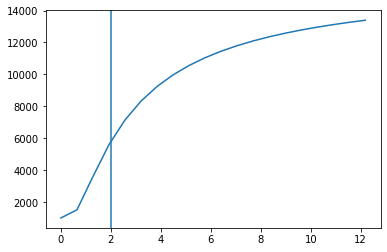

In [81]:
# find loglog scale parameter
sigmas =  np.linspace(np.exp(-5), np.exp(2.5), 20) 
# sigmas = np.exp(sigmas_log)
Ls = []
for sigma in sigmas:
    _, eig = df.diffusion_map(X_identity,sigma=sigma)
    affinity = eig["affinity"]
    Ls.append(affinity.sum())
    
plt.plot(sigmas, Ls)
plt.axvline(x=2.)
plt.show()

In [72]:
# plot eigenvalues 

def inspect_eigenvalues(X_train, title, ts=[1,2], mod=None, show=True, num_eig_plot=None):
    if len(ts) != 2:
        raise Exception(f"ts should be of length 2, but has {len(ts)} values. Can only compare two different values.")
    if mod is not None:
        X_train = modify_dataset(X_train, phi)
    if num_eig_plot is None:
        num_eig_plot = X_train.shape[0]
        
    dm_median_1, eig_median_1 = df.diffusion_map(X_train, sigma=0, t=ts[0])
    dm_adaptive_1, eig_adaptive_1 = df.diffusion_map(X_train, sigma="adaptive", t=ts[0])
    dm_median_2, eig_median_2 = df.diffusion_map(X_train, sigma=0, t=ts[1])
    dm_adaptive_2, eig_adaptive_2 = df.diffusion_map(X_train, sigma="adaptive", t=ts[1])

    fig , [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 4), sharey=True)
    ax1.plot(eig_adaptive_1["vals"][:num_eig_plot]**ts[0], label="adaptive")
    ax1.plot(eig_median_1["vals"][:num_eig_plot]**ts[0], label="median")
    ax1.set_title(f"Eigenvalue decay, {title}, t={ts[0]}")
    ax1.set_ylabel("Value")
    ax1.set_xlabel("Position")
    ax1.legend()
    ax1.grid()

    ax2.plot(eig_adaptive_2["vals"][:num_eig_plot]**ts[1], label="adaptive")
    ax2.plot(eig_median_2["vals"][:num_eig_plot]**ts[1], label="median")
    ax2.set_title(f"Eigenvalue decay, {title}, t={ts[1]}")
    ax2.set_ylabel("Value")
    ax2.set_xlabel("Position")
    ax2.legend()
    ax2.grid()
    if show:
        plt.show()
    return (fig, (ax1, ax2))


def inspect_eigenvalues_for_sigmarange(X_train, sigmas, ts=[1, 2], title="", show=True, num_eig_plot=None):
    if len(ts) != 2:
        raise Exception(f"ts should be of length 2, but has {len(ts)} values. Can only compare two different values.")
    if num_eig_plot is None:
        num_eig_plot = X_train.shape[0]
        
    fig , [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
    for sigma in sigmas:
        df_1, eig_1 = df.diffusion_map(X_train, sigma=sigma, t=ts[0])
        ax1.plot(eig_1["vals"][:num_eig_plot], label=f"sigma={sigma}")
        ax1.set_title(f"Eigenvalue decay, {title}, t={ts[0]}")
        ax1.set_ylabel("Value")
        ax1.set_xlabel("Position")
        ax1.legend()
        ax1.grid()
        
        df_2, eig_2 = df.diffusion_map(X_train, sigma=sigma, t=ts[1])
        ax2.plot(eig_2["vals"][:num_eig_plot], label=f"sigma={sigma}")
        ax2.set_title(f"Eigenvalue decay, {title}, t={ts[1]}")
        ax2.set_ylabel("Value")
        ax2.set_xlabel("Position")
        ax2.legend()
        ax2.grid()
        
    if show:
        plt.show()
    
    return [ax1, ax2]


def inspect_eigenvalues_modified_data(X, title, mod=None):
    if mod is None:
        raise Exception("No modification.")

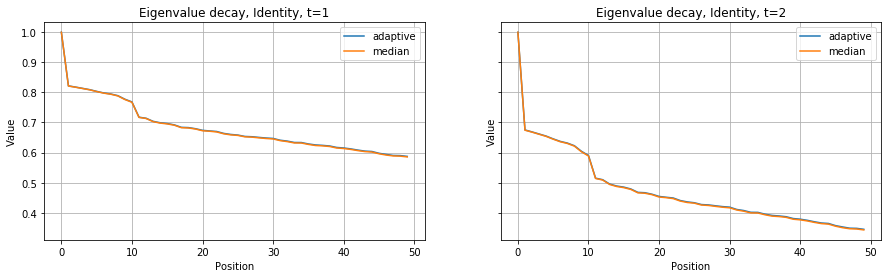

In [78]:
axes_identity = inspect_eigenvalues(X_identity, "Identity", num_eig_plot=50, ts=[1, 2])

Now consider the case when the covariance matrix is diagonal with a gap between the values. 

In [5]:
singular_gap = np.concatenate((20*np.ones(int(d/2)), 0.*np.ones(int(d/2))))
X_gap = generate_gaussian_data(N, d, s=singular_gap, normalize=True)

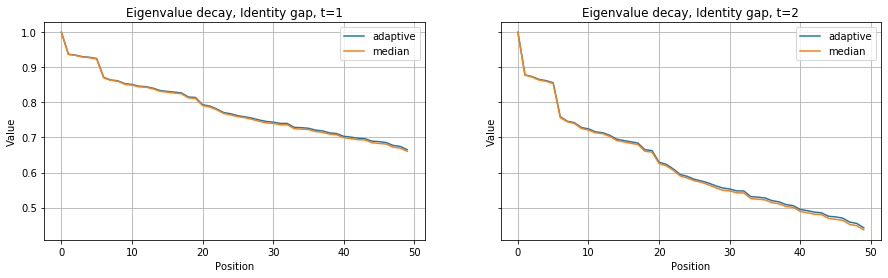

In [75]:
axes_gap = inspect_eigenvalues(X_gap, "Identity gap", num_eig_plot=50)

Consider the case when $\Sigma = U D U^T$, and $D$ is the same as in the previous case.

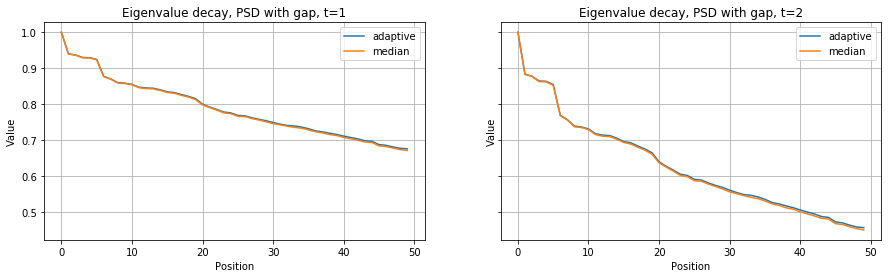

In [76]:
U = ortho_group.rvs(d)
X_decomp_gap = generate_gaussian_data(N, d, U=U, s=singular_gap, normalize=True)
axes_psd = inspect_eigenvalues(X_decomp_gap, "PSD with gap", num_eig_plot=50)

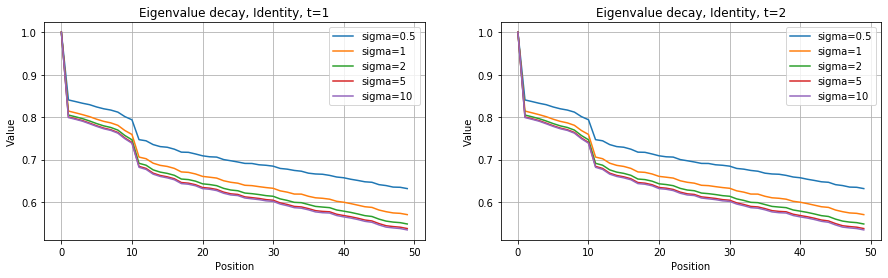

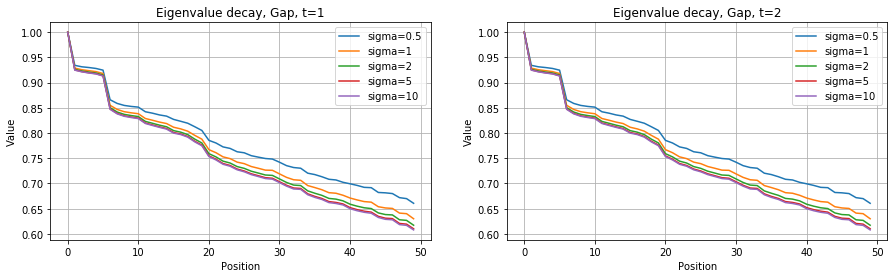

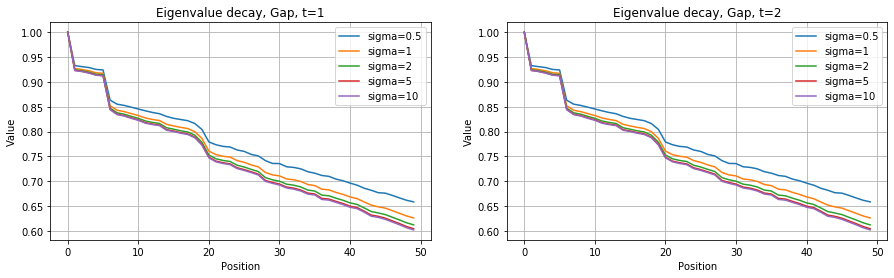

In [66]:
sigmas = [0.5, 1, 2, 5, 10]
axes_variable = inspect_eigenvalues_for_sigmarange(X_identity, sigmas, ts = [1, 2], title="Identity", num_eig_plot=50)
axes_variable = inspect_eigenvalues_for_sigmarange(X_gap, sigmas, ts = [1, 2], title="Gap", num_eig_plot=50)
axes_variable = inspect_eigenvalues_for_sigmarange(X_decomp_gap, sigmas, ts = [1, 2], title="Gap", num_eig_plot=50)

Pretty much the same eigenvalue decay for different t. 

Let's test the case when we have additional information, i.e. when the dataset is $X' = [X, \varphi(X)]$, where $\varphi(X): \mathbb{R}^d \rightarrow \mathbb{R}^k$ such that $x_i \rightarrow (x_i, \varphi (x_i)) \in  \mathbb{R}^{d+k}$

Consider first the case when $k=1$.
Let $\varphi(X) = x_1$, i.e the first column of $X$. 

In [138]:
def modify_dataset(X, mod):
    return np.c_[X, mod(X)]

phi = lambda X: X[:,0]    

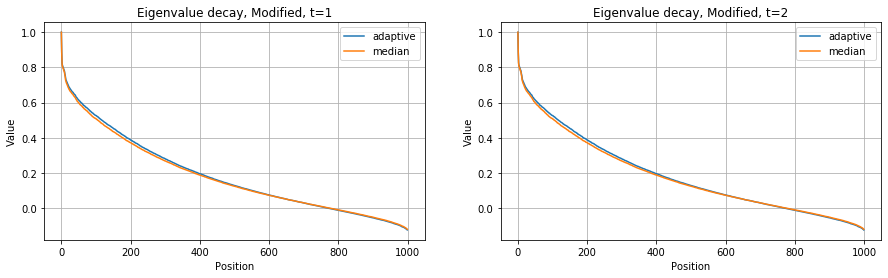

In [144]:
inspect_eigenvalues(X_identity, mod=phi, title="Modified")

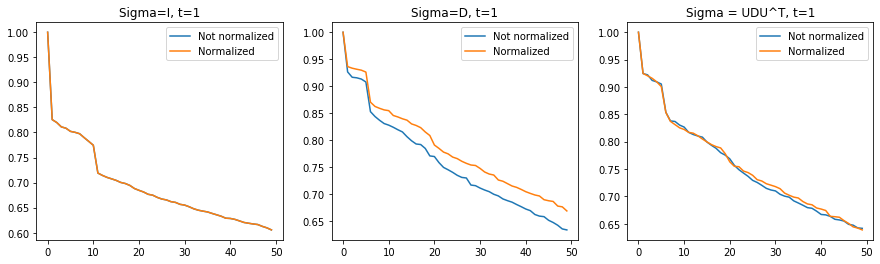

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

X_identity = generate_gaussian_data(N, d, normalize=False)
X_identity_norm = generate_gaussian_data(N, d, normalize=True)
_, eig = df.diffusion_map(X_identity)
_, eig_norm = df.diffusion_map(X_identity)
ax1.plot(eig["vals"][:50], label="Not normalized")
ax1.plot(eig_norm["vals"][:50], label="Normalized")
ax1.set_title("Sigma=I, t=1")
ax1.legend()

X_gap_norm = generate_gaussian_data(N, d, s=singular_gap, normalize=True)
X_gap = generate_gaussian_data(N, d, s=singular_gap, normalize=False)
_, eig = df.diffusion_map(X_gap)
_, eig_norm = df.diffusion_map(X_gap_norm)
ax2.plot(eig["vals"][:50], label="Not normalized")
ax2.plot(eig_norm["vals"][:50], label="Normalized")
ax2.set_title("Sigma=D, t=1")
ax2.legend()

U = ortho_group.rvs(d)
X_decomp_gap = generate_gaussian_data(N, d, U=U, s=singular_gap, normalize=False)
X_decomp_gap_norm = generate_gaussian_data(N, d, U=U, s=singular_gap, normalize=False)

_, eig = df.diffusion_map(X_decomp_gap)
_, eig_norm = df.diffusion_map(X_decomp_gap_norm)

ax3.plot(eig["vals"][:50], label="Not normalized")
ax3.plot(eig_norm["vals"][:50], label="Normalized")
ax3.set_title("Sigma = UDU^T, t=1")
ax3.legend()
plt.show()




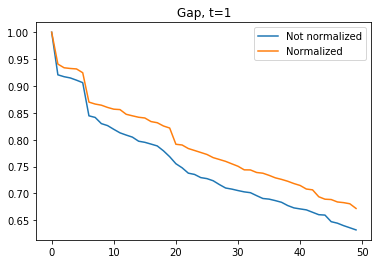

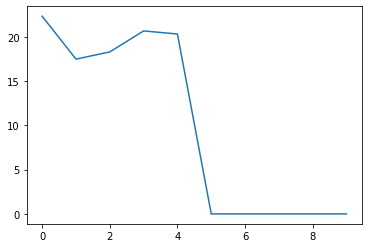

In [57]:
singular_gap

array([20., 20., 20., 20., 20.,  0.,  0.,  0.,  0.,  0.])

In [58]:
np.round(val.real, 3)

array([22.31 , 17.471, 18.284, 20.651, 20.305,  0.   ,  0.   ,  0.   ,
       -0.   , -0.   ])